In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


# 1.定义问题

<font size=3>**背景信息**<br>
<font size=2>&emsp;&emsp; 在覆盖整个城市的共享单车系统网络中，用户可以自助租借、归还自行车。目前，全球有超过 500 个共享单车系统。这些系统生成的数据明确记录了**用户租车时间、出发地点和结束地点等等信息**，充当着传感器网络的作用，可用于研究城市的交通出行行为。 </font>

<font size=2>&emsp;&emsp;在本次比赛中，要求你使用包括天气情况在内的历史数据，来预测华盛顿共享单车系统的租借需求。</font>

<font size=3> &emsp;&emsp;**★ 文件描述** </font>
    
<font size=3>&emsp;&emsp;&emsp;&emsp;**train.csv** - 包含目标变量的训练集 \
    &emsp;&emsp;&emsp;&emsp;**test.csv** - 不包含目标变量的测试集 \
    &emsp;&emsp;&emsp;&emsp;**sampleSubmission.csv** - 格式正确的示例提交文件</font>


<font size=3>&emsp;&emsp;**★ 最终目标：使用租赁期之前可用的信息，来预测测试集每个小时的单车使用量。** </font>

<font size=3>&emsp;&emsp;**★ 评估指标：要求用均方根误差(Root Mean Squared Logarithmic Error, RMSLE)来评价模型的好坏。其数学公式为：**</font>

$$ RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^n [\log(p_i + 1) - \log(a_i + 1)]^2} $$

<font size=3>&emsp;&emsp;&emsp;其中，$n$ 是测试集样本数，$p_i$ 是测试值，$a_i$ 是实际值。当均方根误差越小时，表示数据的拟合效果越好，测试值越接近实际值。</font>

**<font size=3>在数据挖掘中，常见的预处理手段包括：**

* 数据清洗：删除重复记录、处理缺失值、处理异常值、纠正错误数据等。

* 特征选择：从原始数据中选择最有用的特征，以提高模型的精度和效率。

* 特征缩放：对数值型特征进行缩放，以避免某些特征的权重过大或过小而影响模型的表现。

* 数据变换：通过对数据进行归一化、标准化、离散化等处理，使得数据更加符合模型的假设和要求。

* 数据集划分：将原始数据集划分为训练集、验证集和测试集，以便进行模型的训练、评估和优化。

* 特征工程：通过对原始特征进行组合、衍生、转换等操作，构建新的特征，以提高模型的预测能力。

In [2]:
#导包
import numpy as np
import pandas as pd
import seaborn as sn
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import metrics
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

# 2.数据EDA与预处理

In [3]:
# 加载数据
train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

<font size=3>**（1）查看数据集的大小以及包含哪些特征**

In [4]:
train.shape

(10886, 12)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
#测试数据集中没有'casual'和'registered'两列数据，也没有'count'的目标列。
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [7]:
#数值型列的一些基本统计信息，如平均值、标准差、最小值、最大值等。
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


<font size=3>**（2）我们将数据集的列分成了四个不同的部分：数值型、分类型、时间序列和目标。**

* 数值型：温度、体感温度、湿度和风速等四个特征；
    
* 分类型：季节、假期和天气等三个特征；

* 时间序列：日期和时间等一个特征；

* 目标：是预测自行车租赁数量，即'count'列。

In [8]:
# numerical columns
numeric_cols = ['temp', 'atemp','humidity', 'windspeed']
# categorical columns
category_cols = ['season', 'holiday', 'weather']
# time series column 
['datetime']
# target
target = 'count'

In [9]:
def parse_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['week'] = df['datetime'].dt.isocalendar().week
    df['weekday'] = df['datetime'].dt.dayofweek
parse_datetime(train)
parse_datetime(test)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,52,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,52,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,52,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,52,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,52,5


<font size=3>**（3）查看那些特征具有缺失**
    
* 通过调用自定义函数missing(train)，可以得到训练集中每个列的缺失值数量和百分比的统计结果。最终结果是没有缺失值。

In [10]:
def missing (df):
    """
    calculate % missing value for each column
    """
    missing_number = df.isnull().sum().sort_values(ascending=False)                              
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)         
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['missNum', 'missPercent'])   
    return missing_values

missing(train)

,missNum,missPercent
datetime,0,0.0
season,0,0.0
week,0,0.0
hour,0,0.0
day,0,0.0
month,0,0.0
year,0,0.0
count,0,0.0
registered,0,0.0
casual,0,0.0


In [11]:
for feature in train[category_cols]:
        print(f'{feature}: {train[feature].unique()}')

season: [1 2 3 4]
holiday: [0 1]
weather: [1 2 3 4]


* 通过调用自定义函数find_index，检查是否用空格代替了缺失值。返回值均为-1，数据未使用空格代替缺失值。

In [12]:
# 检查是否用空格代替了缺失值
def find_index(data_col, val):
   
    val_list = [val]
    if data_col.isin(val_list).sum() == 0:
        index = -1
    else:
        index = data_col.isin(val_list).idxmax()
    return index

for col in numeric_cols:
    print(find_index(train[col], " "))
    

-1
-1
-1
-1


* 通过调用自定义函数find_index，检查是否用0代替了缺失值。对于每个数值型列，都调用find_index函数查找0值的索引，并将其添加到is_0列表中。最终结果为‘humidity’和‘windspeed’两列存在0值。之后通过调用zero_missing_percent(train, 'windspeed')和zero_missing_percent(train, 'humidity')，可以得到在'windspeed'列和'humidity'列中值为0的缺失值数量和百分比。最后调用自定义函数wind_mean_fill和humidity_mean_fill在训练集和测试集上都可以使用列的平均值填充0值，从而解决了缺失值的问题。

In [13]:
# 检查是否用0代替了缺失值
def find_index(data_col, val):
    val_list = [val]
    if data_col.isin(val_list).sum() == 0:
        index = -1
    else:
        index = data_col.isin(val_list).idxmax()
    return index

is_0 = []
for col in numeric_cols:
    is_0.append(find_index(train[col], 0))

numeric_cols = ['temp', 'atemp','humidity', 'windspeed']
missing_check_0 = pd.DataFrame({'cols': numeric_cols, 'is_0': is_0})
missing_check_0


,cols,is_0
0,temp,-1
1,atemp,-1
2,humidity,1091
3,windspeed,0


In [14]:
print(train['windspeed'].unique())
print(train['humidity'].unique())

[ 0.      6.0032 16.9979 19.0012 19.9995 12.998  15.0013  8.9981 11.0014
 22.0028 30.0026 23.9994 27.9993 26.0027  7.0015 32.9975 36.9974 31.0009
 35.0008 39.0007 43.9989 40.9973 51.9987 46.0022 50.0021 43.0006 56.9969
 47.9988]
[ 81  80  75  86  76  77  72  82  88  87  94 100  71  66  57  46  42  39
  44  47  50  43  40  35  30  32  64  69  55  59  63  68  74  51  56  52
  49  48  37  33  28  38  36  93  29  53  34  54  41  45  92  62  58  61
  60  65  70  27  25  26  31  73  21  24  23  22  19  15  67  10   8  12
  14  13  17  16  18  20  85   0  83  84  78  79  89  97  90  96  91]


In [15]:
def zero_missing_percent(data, miss_col):
    miss_num = train[train[miss_col]==0].shape[0]
    miss_pct = round(miss_num/train.shape[0],4)
    print(f"There are {miss_num} missing values in {miss_col} column so missing percentage is {miss_pct}")

zero_missing_percent(train, 'windspeed')
zero_missing_percent(train, 'humidity')

There are 1313 missing values in windspeed column so missing percentage is 0.1206
There are 22 missing values in humidity column so missing percentage is 0.002


In [16]:
def wind_mean_fill(df):
    mean_windspeed = df['windspeed'].mean()
    df['windspeed'] = df['windspeed'].replace(0, mean_windspeed)
    return df

# 在训练集上使用平均值填充
train = wind_mean_fill(train)

# 在测试集上使用平均值填充
test = wind_mean_fill(test)

In [17]:
def humidity_mean_fill(df):
    mean_humidity = df['humidity'].mean()
    df['humidity'] = df['humidity'].replace(0, mean_humidity)
    return df

# 在训练集上使用平均值填充
train = humidity_mean_fill(train)

# 在测试集上使用平均值填充
test = humidity_mean_fill(test)


<font size=3>**（4）查看哪些特征具有异常值(离群值)**

* 自定义函数detect_outliers_3sigma利用3σ原则来检测数据中的异常值。根据3σ原则，数据点与均值的偏差超过3倍标准差的被认为是异常值。通过绘制箱线图和打印边界值，可以直观地了解数据的分布情况和异常值的位置。最后，使用自定义函数delete_outliers删除这些异常值所在的行并打印删除的异常值数量以及删除异常值前后数据框的形状。

In [18]:
def detect_outliers_3sigma(data):
    # calculate the mean and standard deviation of the data
    mean = np.mean(data)
    std = np.std(data)
    
    # define the cutoff for what constitutes an outlier
    cutoff = 3 * std
    
    # boxplot
    sn.boxplot(data, orient="v")
    plt.show()
    
    # print lower, upper boundry
    lower, upper = mean-3*std, mean+3*std
    print(f"The lower/upper boundary is {lower}/{upper}")
    
    # identify outliers
    outliers = [x for x in data if np.abs(x - mean) > cutoff]
    print(f"There are {len(outliers)} outliers based on 3-sigma rule")
    #return outliers


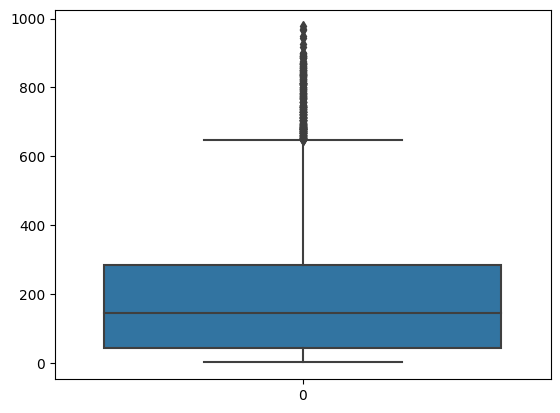

The lower/upper boundary is -351.8342688102495/734.9825326353459
There are 147 outliers based on 3-sigma rule


In [19]:
detect_outliers_3sigma(train['count'])

In [20]:
def delete_outliers(data, df):
    original_shape = df.shape
    mean = np.mean(data)
    std = np.std(data)
    outliers=np.abs(data-mean) > (3*std)
    outliers_num = len(train[outliers])
    df.drop(index=data[outliers].index, inplace=True)
    print("Have already deleted",outliers_num,"outliers")
    print ("Shape Before Delete Ouliers: ",original_shape)
    print ("Shape After Delete Ouliers: ",df.shape)

In [21]:
delete_outliers(train['count'], train)

Have already deleted 147 outliers
Shape Before Delete Ouliers:  (10886, 18)
Shape After Delete Ouliers:  (10739, 18)


# 3.特征工程

<font size=3>2011年至2012年的共享单车整体租赁量情况

<font size=3>受季节因素影响显著，其中，春季最少，夏季秋季最多，冬季租车量要高于春季。(这里回答了开头提出的第二个问题。)
注册用户是租车主力，租车比例基本每月都在75%以上。
注册用户在夏季和秋季的租车比例（80%）低于春季和冬季（90%）。也就是说非注册用户夏秋租车占比高于春冬，即非注册用户更倾向于在天气情况较为暖和的夏季和秋季租车。


* <font size=3>**这段代码自定义了一个名为`parse_datetime`的Python函数**

该函数用于解析日期时间列，并将其拆分为年、月、日、小时、周数和工作日。

然后调用了`parse_datetime`函数来处理训练集和测试集中的日期时间列。

In [22]:
def get_day(day_start):
   day_end = day_start + pd.offsets.DateOffset(hours=23)
   return pd.date_range(day_start, day_end, freq="H")

In [23]:
# set datetime as index
dt = pd.DatetimeIndex(train['datetime'])
train.set_index(dt, inplace=True)
dtt = pd.DatetimeIndex(test['datetime'])
test.set_index(dtt, inplace=True)
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")


* <font size=3> **首先对4个类别特征进行可视化**

        
     * **星期几对使用量的影响( weekday → count )** 
     图1：星期几对单车总使用量没有太大的影响。

    * **季节对使用量的影响( season → count )** 
    图2：可以看到冬春相对夏秋使用量相对较少，与上面月份产生的结论相互印证。
    
     * **工作日对使用量的影响( workingday → count )** 
    图3：是否工作日对单车总使用量也基本没有太大的影响。

    * **一天中不同时间段对使用量的影响( hour → count )** 
    图4：在一天中不同时间段，共享单车使用量差异明显，在8点和16-19点明显多于其他时间点，考虑到的原因是在这期间是上下班的高峰期；在0-5点明显低于其他时间点，考虑到的原因是在此期间为睡眠时间。
   

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Hour Of The Day')]

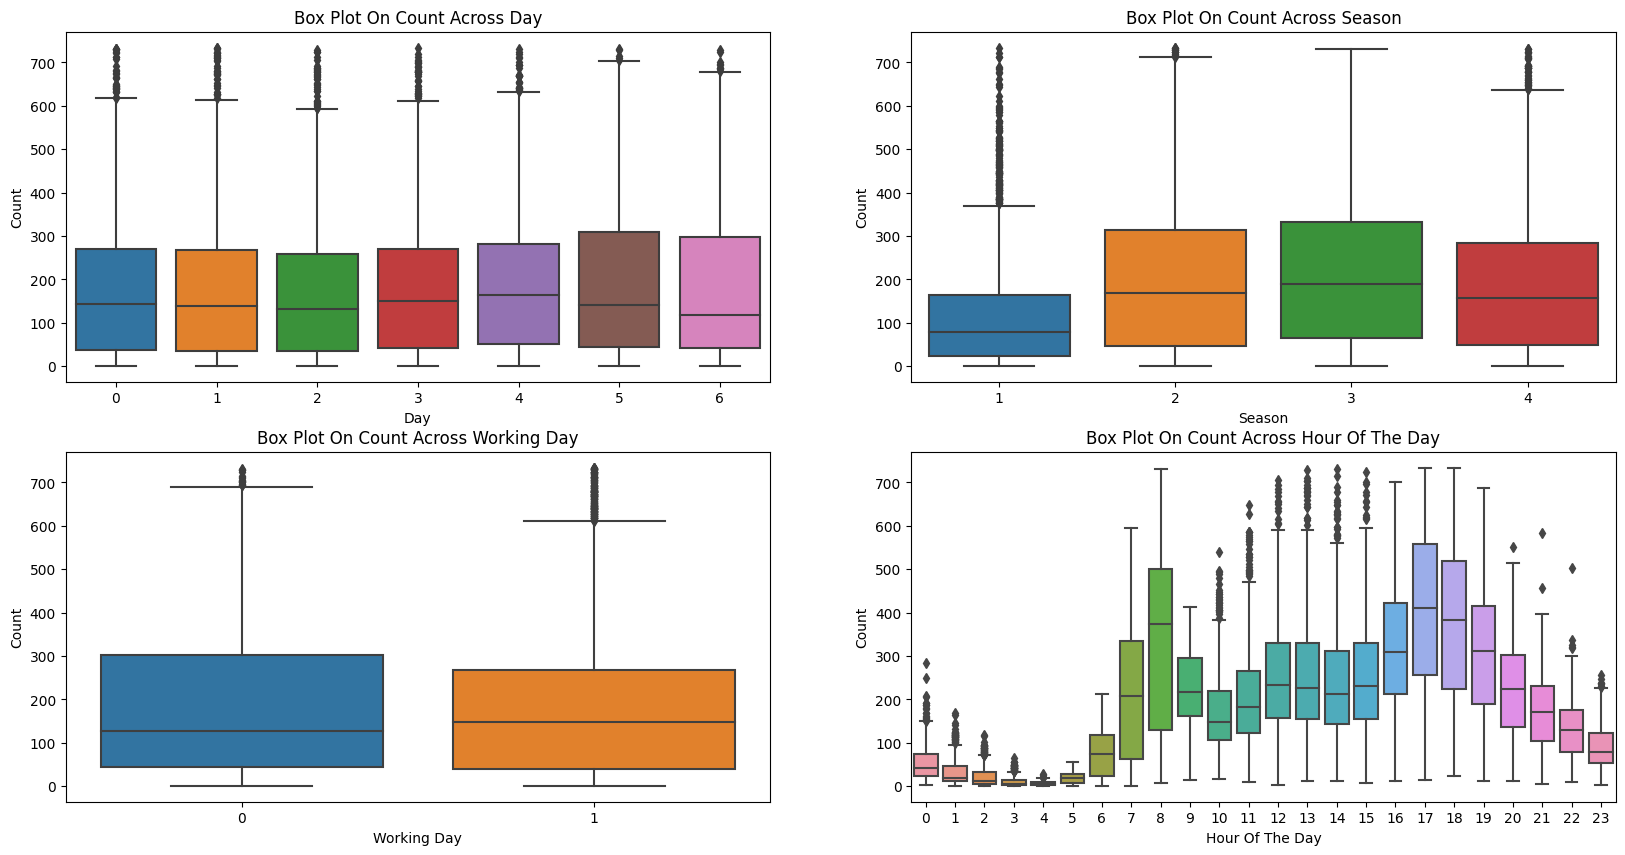

In [24]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 10)

sn.boxplot(data=train,y="count",x='weekday',orient="v",ax=axes[0][0])
sn.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][0])
sn.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][1])

axes[0][0].set(xlabel='Day',ylabel='Count',title="Box Plot On Count Across Day")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[1][1].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")


* <font size=3>**注册用户和非注册用户对使用量的影响( registered → count & casual → count )**
 
    由下图可以得知，注册用户的使用量占据了单车总使用量的绝大多数，并且趋势与总使用量趋势一致，而非注册用户，一天中不同时段的使用量没有太大变化，这说明使用量主要注册用户决定，注册用户更有粘性。

In [25]:
melt_df = pd.melt(train[["hour", "casual", "registered", "count"]], id_vars=["hour"], value_vars=["casual", "registered", "count"])
melt_df.head()

,hour,variable,value
0,0,casual,3
1,1,casual,8
2,2,casual,5
3,3,casual,3
4,4,casual,0


In [26]:
melt_group_df = melt_df.groupby(["hour", "variable"])["value"].mean().reset_index()
melt_group_df.head()

,hour,variable,value
0,0,casual,10.312088
1,0,count,55.138462
2,0,registered,44.826374
3,1,casual,6.513216
4,1,count,33.859031


<Axes: xlabel='hour', ylabel='value'>

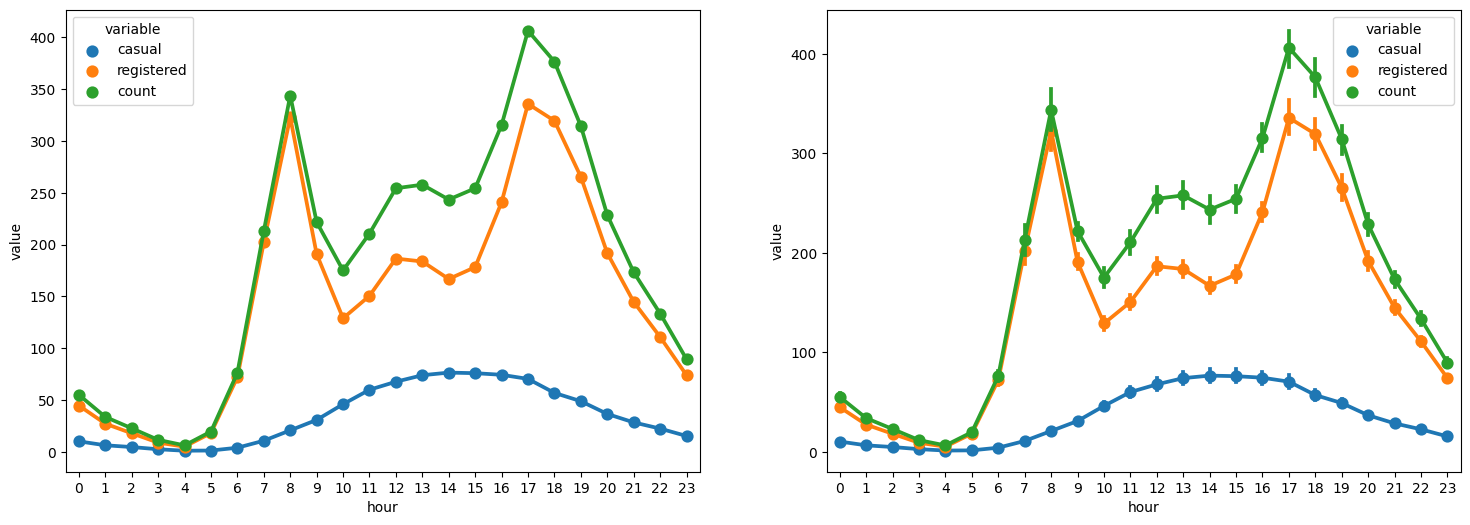

In [27]:
import seaborn as sns

plt.figure(figsize=(18, 6))
plt.subplot(121)
variable_order = ['casual', 'registered', 'count']
sns.pointplot(x="hour", y="value", hue="variable", hue_order=variable_order, data=melt_group_df)
plt.subplot(122)
sns.pointplot(x="hour", y="value", hue="variable", hue_order=variable_order, data=melt_df)

* <font size=3>**由天气状况-租车数据图可见：**

天气状况好时的租车量高于天气状况差的时候。晴天/少云和多云/薄雾天气下的租车量明显高于雨雪天气时。暴雨/大学天气只出现了一次，因此平均租车数据不具参考性。
晴天/少云天气下的总租车量大大超过其他天气状况，可以判断华盛顿特区气候宜人，天气多以晴天/少云为主。



In [28]:
weather_rental=train[['weather','casual','registered','count']]
weather_rental['weather']=weather_rental['weather'].map({1:'Clear,Partly cloudy',2:'Mist + Cloudy',3:'Light Snow, Light Rain',
                              4:'Heavy Rain，snow'})
weather_rental.head()

,weather,casual,registered,count
datetime,,,,
2011-01-01 00:00:00,"Clear,Partly cloudy",3,13,16
2011-01-01 01:00:00,"Clear,Partly cloudy",8,32,40
2011-01-01 02:00:00,"Clear,Partly cloudy",5,27,32
2011-01-01 03:00:00,"Clear,Partly cloudy",3,10,13
2011-01-01 04:00:00,"Clear,Partly cloudy",0,1,1


In [29]:
weather_rental_gb=weather_rental.groupby('weather').agg({'weather':'count','count':sum}).rename(columns={'weather':'weather_count',
                                                                                                        'count':'rental'}).reset_index().sort_values('rental',ascending=False)
weather_rental_gb['average hourly rental']= weather_rental_gb['rental']/weather_rental_gb['weather_count']
weather_rental_gb.head()

,weather,weather_count,rental,average hourly rental
0,"Clear,Partly cloudy",7076,1380889,195.151074
3,Mist + Cloudy,2809,487051,173.389462
2,"Light Snow, Light Rain",853,97174,113.920281
1,Heavy Rain，snow,1,164,164.000000


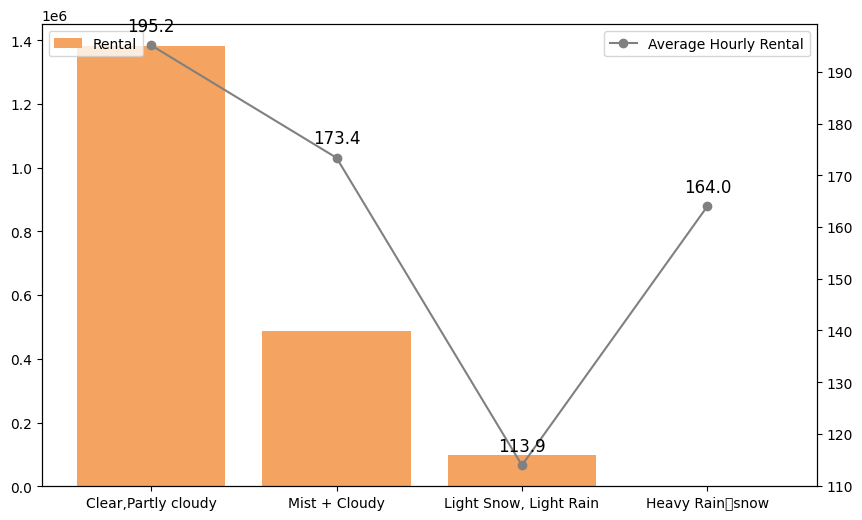

In [30]:
import warnings

warnings.filterwarnings("ignore")

fig, ax9 = plt.subplots(figsize=(10, 6))
# 绘制柱状图
ax9.bar(weather_rental_gb['weather'], weather_rental_gb['rental'], color='sandybrown', label='Rental')

# 创建第二个y轴
ax10 = ax9.twinx()
# 绘制折线图
ax10.plot(weather_rental_gb['weather'], weather_rental_gb['average hourly rental'], color='gray', marker='o', label='Average Hourly Rental')

# 添加数值标签
x = weather_rental_gb['weather']
y2 = weather_rental_gb['average hourly rental']
for a, b in zip(x, y2):
    ax10.text(a, b + 2, '%.1f' % b, ha='center', va='bottom', fontsize=12)


# 显示图例
ax9.legend(loc='upper left')
ax10.legend(loc='upper right')

plt.show()


* <font size=3>**绘制特征之间的相关性热力图**
   要理解目标变量如何受数值特征影响的一个常见方法是找出它们之间的相关矩阵，绘制 count 与 [temp, atemp, humidity, windspeed, casual, registered] 之间的相关矩阵热图。
    - **humidity 与 count 呈负相关，temp 等其他特征与 count 呈负相关。**
    - **temp 和 atemp 之间有很强的相关性，都纳入模型的话会造成多重共线性问题，所以必须删除其中一个特征。我们删除 atemp 特征，因为它与 count之间的相关性较 temp 弱。**
    - **casual 和 registered 也不考虑在内，因为它们本质上是泄漏变量，测试集中也没有它们的数值，所以需要在模型构建过程中删除。** 
- 这样，建模时我们主要考虑 **"temp" "humidity" "windspeed"** 这 3 个数值特征。

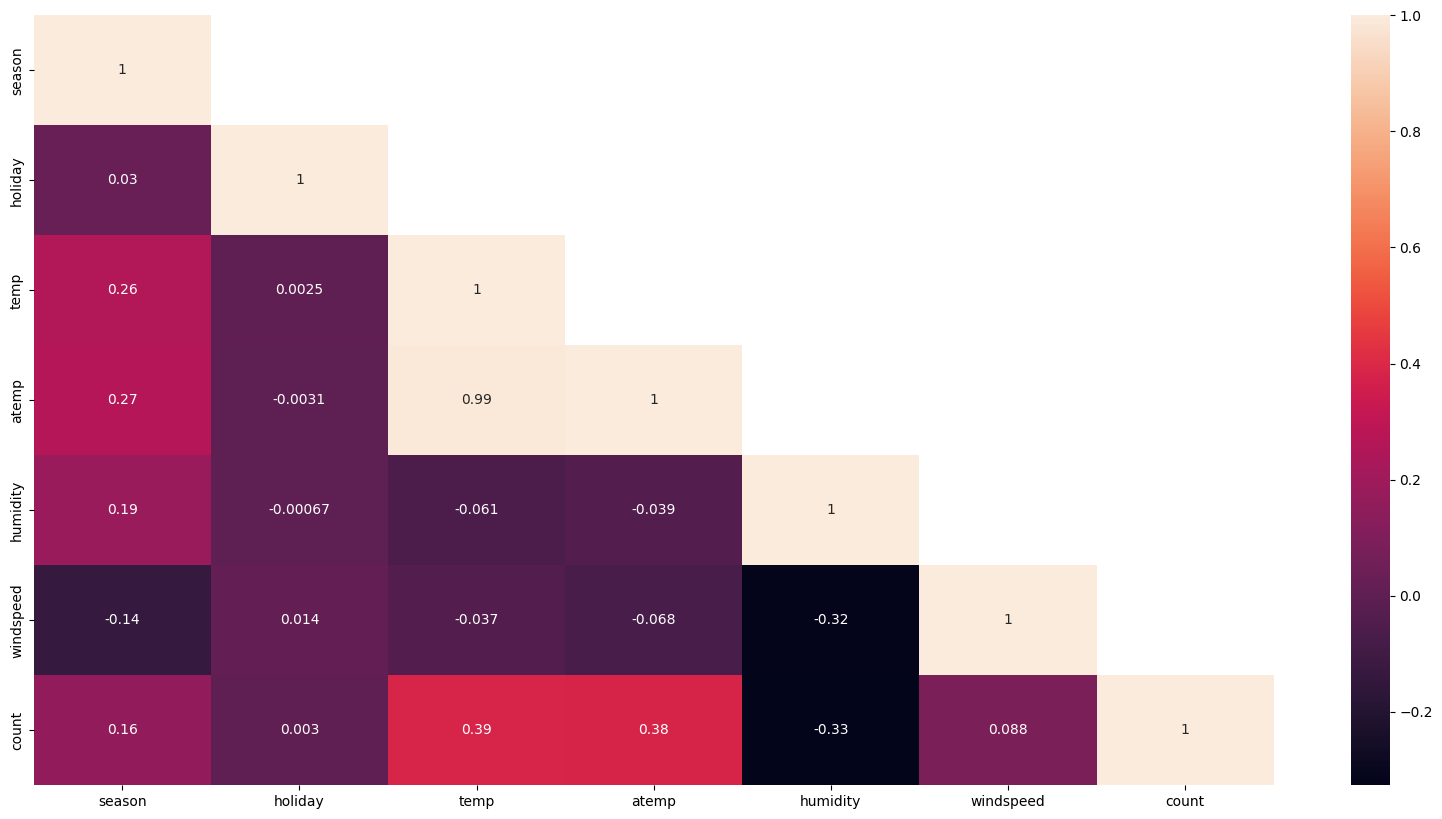

In [31]:
def correlation_heatmap(corr):
    mask = np.array(corr)
    mask[np.tril_indices_from(mask)] = False
    fig,ax= plt.subplots()
    fig.set_size_inches(20,10)
    sn.heatmap(corr, annot=True, mask=mask)

corr = train[['season', 'holiday','temp', 'atemp','humidity', 'windspeed', 'count']].corr()
correlation_heatmap(corr)

<Axes: ylabel='Density'>

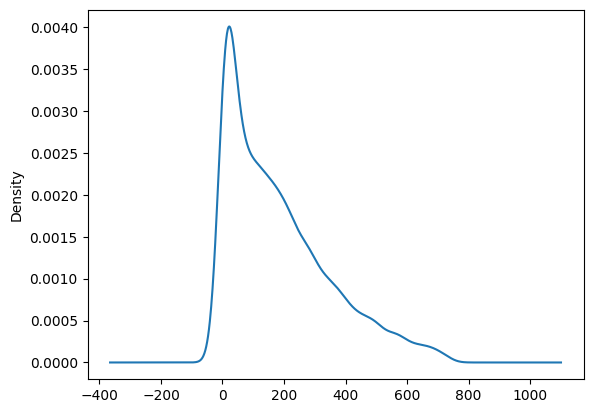

In [32]:
# Kernel Density Estimation plot 
train['count'].plot(kind='kde')

<Axes: ylabel='Density'>

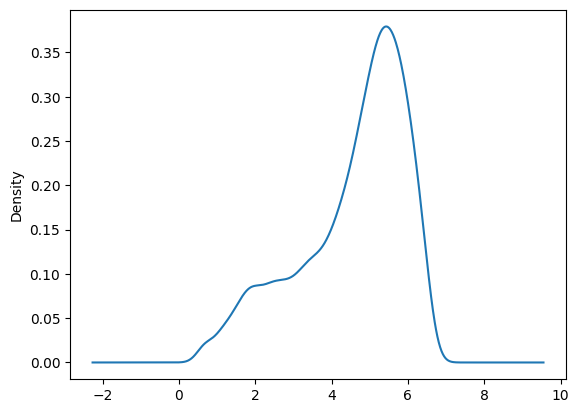

In [33]:
# log trnasformation for skewed count data
import math
train['count_log']=np.log1p(train['count'])
train['count_log'].plot(kind='kde')

# 4.模型构建

* 通过计算RMSLE指标，我们可以评估模型在回归任务中的性能，值越低表示模型的预测结果与真实结果之间的差异越小。

In [34]:
#RMSLE
def rmsle(y_real, y_pre):    
    log1 = np.log1p(y_real)
    log2 = np.log1p(y_pre)    
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [35]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'week', 'weekday', 'count_log'],
      dtype='object')

In [36]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour',
       'week', 'weekday'],
      dtype='object')

In [37]:
drop_columns = ['count', 'count_log', 'casual', 'registered', 'datetime']
X_train = train.drop(drop_columns,axis = 1).values
X_test = test.drop(['datetime'],axis = 1).values

yLog = train['count_log'].values
x_date = test['datetime'].values

In [38]:
rf_columns = [
    'weather', 'temp', 'windspeed',
    'workingday', 'season', 'holiday',
    'hour', 'weekday', 'week',
]
gb_columns =[
    'weather', 'temp', 'humidity', 'windspeed',
    'workingday', 'season', 'holiday',
    'hour', 'weekday', 'year', 
]

* 转换数据为适合机器学习模型训练的格式，包括准备特征数据和目标数据，并对目标数据进行了对数转换以满足模型的假设条件。

In [39]:
rf_x_train=train[rf_columns].values
rf_x_test=test[rf_columns].values

gb_x_train=train[gb_columns].values
gb_x_test=test[gb_columns].values

y_casual=train['casual'].apply(lambda x: np.log1p(x)).values
y_registered=train['registered'].apply(lambda x: np.log1p(x)).values
y=train['count'].apply(lambda x: np.log1p(x)).values

X_date=test['datetime'].values

* 将原始数据集划分为训练集和测试集，以便于进行模型的训练和评估。

In [40]:
# 划分数据集
from sklearn.model_selection import train_test_split
drop_columns = ['count', 'count_log', 'casual', 'registered', 'datetime']
X_train = train.drop(drop_columns, axis = 1).values
xd_train,xd_test,yd_train,yd_test = train_test_split(X_train,y,random_state=0)

In [41]:
lgb_model = lgb.LGBMRegressor()

def LGB_model():
    lgb_parameters = {'random_state': [42], 
                  'n_estimators': [100, 200, 300], 
                  'max_depth': [4, 5], 
                  'learning_rate': [0.1]}
    rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

    gs = GridSearchCV(estimator=lgb_model, param_grid=lgb_parameters, scoring=rmsle_scorer, cv=5)
    gs.fit(xd_train, yd_train)
    print('Best params for LightGBM model are: ', gs.best_params_)

    test_pred = gs.predict(xd_test)
    score = rmsle(yd_test, test_pred)
    return score

score = LGB_model()
print('Score: ', score)


Best params for LightGBM model are:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'random_state': 42}
Score:  0.07599719569625975


## XGBoost

In [42]:
xgb_model = xgb.XGBRegressor()
def XGB_model():
    xgb_parameters = {'random_state': [42], 
                  'n_estimators': [300, 370, 400], 
                  'max_depth': [4, 5], 
                  'learning_rate': [0.1]}
    rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)

    gs = GridSearchCV(estimator = xgb_model, param_grid = xgb_parameters, scoring = rmsle_scorer, cv = 5)
    gs.fit(xd_train, yd_train)
    print('Best params for XGBoost model are: ', gs.best_params_)
    #
    test_pred = gs.predict(xd_test)
    # calculate RMSLE
    score = rmsle(yd_test,test_pred)
    return score
score = XGB_model()
print('Score: ', score)

Best params for XGBoost model are:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'random_state': 42}
Score:  0.07568095274801738


#  RandomForestRegressor

In [43]:
from sklearn.ensemble import RandomForestRegressor
def RandomForest_model():
    params = {'n_estimators': 1000, 
              'max_depth': 15, 
              'random_state': 0, 
              'min_samples_split' : 2, 
              'n_jobs': -1}

    rfr = RandomForestRegressor(**params)
    rfr.fit(xd_train, yd_train)
    test_pred = rfr.predict(xd_test)
    # calculate RMSLE
    score = rmsle(yd_test,test_pred)
    return score
score = RandomForest_model()
print('Score: ', score)

Score:  0.08192542850762563


# GradientBoostingRegressor

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
def GradientBoosting_model():
    gbr = GradientBoostingRegressor(n_estimators = 1000, 
                                    max_depth = 5, 
                                    random_state = 0)
    gbr.fit(xd_train,yd_train)
    test_pred = gbr.predict(xd_test)
    score = rmsle(yd_test,test_pred)
    return score
score = RandomForest_model()
print('Score: ', score)

Score:  0.08192542850762563


In [45]:
# XGBoost
xgb_params = {'random_state': 42, 
              'n_estimators': 200, 
              'max_depth': 5, 
              'learning_rate': 0.1}

XGB1 = xgb.XGBRegressor(**xgb_params)
XGB1.fit(gb_x_train,y_casual)
print("model score for prediting casual count:",XGB1.score(gb_x_train,y_casual))

XGB2 = xgb.XGBRegressor(**xgb_params)
XGB2.fit(gb_x_train,y_registered)
print("model score for prediting registered count:",XGB2.score(gb_x_train,y_registered))

XGB3 = xgb.XGBRegressor(**xgb_params)
XGB3.fit(gb_x_train,y)
print("model score for prediting count:",XGB3.score(gb_x_train,y))

model score for prediting casual count: 0.9228744961426909
model score for prediting registered count: 0.9695863141047706
model score for prediting count: 0.9697463573506641


<Figure size 1500x1200 with 0 Axes>

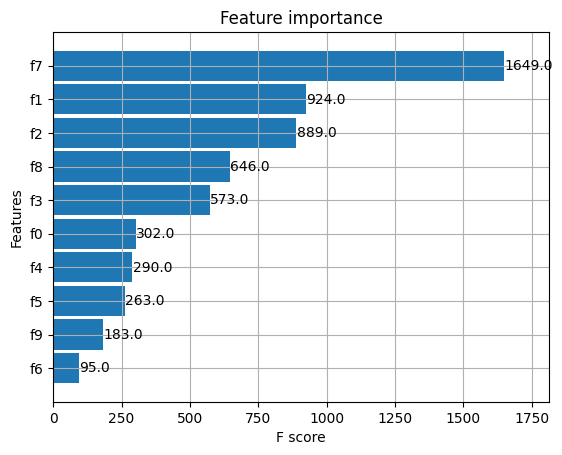

In [46]:
from xgboost import plot_importance, plot_tree
fig = plt.figure(figsize=(15,12))
fig = plot_importance(XGB3, height=0.9,max_num_features = 25)
plt.show()

In [47]:
# gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

gbr_params = {'n_estimators': 150, 
       'max_depth': 5, 
       'random_state': 0, 
       'min_samples_leaf': 9, 
       'learning_rate': 0.01, 
       'subsample': 0.7, 
       'loss': 'squared_error'}


GBR1 = GradientBoostingRegressor(**gbr_params)
GBR1.fit(gb_x_train,y_casual)
print("model score for prediting casual count:",GBR1.score(gb_x_train,y_casual))

GBR2 = GradientBoostingRegressor(**gbr_params)
GBR2.fit(gb_x_train,y_registered)
print("model score for prediting registered count:",GBR2.score(gb_x_train,y_registered))

GBR3 = GradientBoostingRegressor(**gbr_params)
GBR3.fit(gb_x_train,y)
print("model score for prediting count:",GBR3.score(gb_x_train,y))


model score for prediting casual count: 0.8075341954570694
model score for prediting registered count: 0.8281127285476739
model score for prediting count: 0.8332163179507687


In [48]:
import lightgbm as lgb

lgb_params = {'n_estimators': 150, 
              'max_depth': 5, 
              'random_state': 0, 
              'learning_rate': 0.1, 
              'min_split_gain': 0.5, 
              'subsample': 0.7}

LGB1 = lgb.LGBMRegressor(**lgb_params)
LGB1.fit(gb_x_train,y_casual)
print("Model score for predicting casual count:", LGB1.score(gb_x_train, y_casual))

LGB2 = lgb.LGBMRegressor(**lgb_params)
LGB2.fit(gb_x_train, y_registered)
print("Model score for predicting registered count:", LGB2.score(gb_x_train, y_registered))

LGB3 = lgb.LGBMRegressor(**lgb_params)
LGB3.fit(gb_x_train, y)
print("Model score for predicting count:", LGB3.score(gb_x_train, y))



Model score for predicting casual count: 0.9029644301421333
Model score for predicting registered count: 0.9520244400996091
Model score for predicting count: 0.9519546801168297


In [49]:
def prediction(x_test, models):
    prediction = []
    for model in models:
        pre = model.predict(x_test)
        pre = np.expm1(pre)
        prediction.append(pre)
    return sum(prediction)

pred_xgb = prediction(gb_x_test, models=[XGB1, XGB2])
pred_gbr = prediction(gb_x_test, models=[LGB1, LGB2])

In [50]:
prediction = (0.95* pred_xgb) + (0.05*pred_gbr)

In [51]:
submit = pd.DataFrame({'datetime':x_date,'count':prediction})
submit.to_csv('/kaggle/working/submisssion.csv',index=False)